# Social Reward Second Level Analyses

## Set Up

### Import packages

In [1]:
import os
import glob
import pandas as pd
import numpy as np

from matplotlib.gridspec import GridSpec

# Import cerebellum packages
import matplotlib.pyplot as plt
import SUITPy.flatmap as flatmap

from nilearn.glm.second_level import make_second_level_design_matrix
from nilearn.plotting import plot_design_matrix, plot_stat_map
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img, cluster_level_inference



Matplotlib created a temporary config/cache directory at /tmp/matplotlib-7_vr7e55 because the default path (/afs/glue.umd.edu/home/glue/h/p/hpopal/home/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
/export/software/neuron/new_conda/envs/py37/lib/python3.7/site-packages/nilearn/__init__.py:67: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()


### Define Functions

In [2]:
def plot_stat_contours(filename, thresh=1, mc_alpha=0.001, clust_alpha=0.05, view='split', title=''):
    # Find type of analysis
    analysis = 'group'
    
    # Find stat map
    stat_filename = os.path.join(data_dir, analysis,  
                                    filename+'_unc.nii.gz')
    stat_filename_mc = os.path.join(data_dir, analysis,  
                                    filename+'_fpr-'+str(mc_alpha)+'_clust-'+str(clust_alpha)+'.nii.gz')
    
    # Import stat map as a cerebellum flatmap
    funcdata = flatmap.vol_to_surf(stat_filename,
                                  space='SUIT')
    
    
    
    mc_thresh = threshold_data[filename+'_fpr-'+str(mc_alpha)]
    print(mc_thresh)
    if mc_thresh == np.inf:
        mc_thresh = 1000

    if view == 'split':
        # Set figure specs
        fig = plt.figure(figsize=(15, 4))
        gs = GridSpec(2, 3)
        ax_img1 = plt.subplot(gs[0, :2])
        ax_img2 = plt.subplot(gs[1, :2])
        
        hemi_lh = plot_stat_map(stat_filename, threshold=thresh, axes=ax_img1,
                                cut_coords=range(-65,0, 10), display_mode='x', colorbar=True,
                                cmap='coolwarm', symmetric_cbar=True, title='Left Hemisphere',
                                annotate=False)
        hemi_rh = plot_stat_map(stat_filename, threshold=thresh, axes=ax_img2,
                                cut_coords=range(66,5, -10), display_mode='x', colorbar=True,
                                cmap='coolwarm', symmetric_cbar=True, title='Right Hemisphere',
                                annotate=False)
        hemi_lh.add_contours(stat_filename_mc, levels=[-0.1,0.1], colors=['blue','red'], 
                          alpha=1, linewidths=1)
        hemi_rh.add_contours(stat_filename_mc, levels=[-0.1,0.1], colors=['blue','red'], 
                          alpha=1, linewidths=1)
        
        ax_joint = plt.subplot(gs[:, 2:])
        ax_joint.set(title='Cerebellum flatmap')
        flatmap.plot(data=funcdata, cmap='hot',
                    threshold=[-mc_thresh,mc_thresh],
                    colorbar=False,
                    render='matplotlib', new_figure=False)
        
    elif view == 'straight':
        hemi_bh = plot_stat_map(stat_filename, threshold=thresh, 
                      cut_coords=range(-65,66, 10), display_mode='x', colorbar=True,
                      cmap='coolwarm', symmetric_cbar=True, title=title)
        hemi_bh.add_contours(stat_filename_mc, levels=[-0.1,0.1], colors=['blue','red'], 
                          alpha=1, linewidths=2)

### Set directories and import subject data

In [3]:
#bids_dir = '/data/projects/social_doors/'
bids_dir = '/data/neuron/SCN/SR/'


os.chdir(bids_dir)

data_dir = os.path.join(bids_dir, 'derivatives','SR_first_level')
outp_dir = data_dir+'group/'

# Import scan info for runs that passed QC
subjs_scan_info = pd.read_csv(bids_dir+'/derivatives/participants_good.csv')

# Create a participant list for only those with good scans
subjs_list = list(subjs_scan_info['participant_id'].unique())
subjs_list.sort()

# Import other participant info like demographics
subjs_info = pd.read_csv(bids_dir+'participants.tsv', sep='\t', index_col=0)
#subjs_info = subjs_info.rename(columns={'participant_id': 'subject_label'})

# Filter for only participants with good scan data
subjs_info = subjs_info.loc[subjs_list]

# Rename group IDs
subjs_info['group'] = subjs_info['group'].map({1: 'not_asd', 2: 'asd'})

# Reset index to make participant IDs a column
subjs_info = subjs_info.reset_index()


subjs_info_typ = subjs_info[subjs_info['group']=='not_asd']
subjs_info_asd = subjs_info[subjs_info['group']=='asd']

#subjs_list = subjs_info.index.to_list()
subjs_list_typ = subjs_info_typ['participant_id'].to_list()
subjs_list_asd = subjs_info_asd['participant_id'].to_list()

print('Found '+str(len(subjs_list_typ))+' non-autistic participants')
print('Found '+str(len(subjs_list_asd))+' autistic participants')

Found 52 non-autistic participants
Found 21 autistic participants


# Non-Autistic Adolescents

In [4]:
# Filter for releveant data
#subjs_info_fltr = subjs_info[['participant_id', 'age']]
#subjs_info_kids_fltr = subjs_info_kids[['subject_label','age']]
#subjs_info_colg_fltr = subjs_info_colg[['subject_label','age']]

<AxesSubplot:label='conditions', ylabel='scan number'>

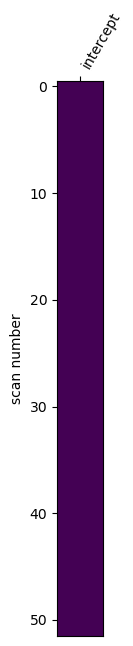

In [5]:
design_matrix = make_second_level_design_matrix(subjs_list_typ)

plot_design_matrix(design_matrix)

In [6]:
def plot_stat_map_cb(filename, threshold):
    # Find stat map
    stat_filename = os.path.join(data_dir,'group',filename+'unc.nii.gz')
    clst_filename = os.path.join(data_dir,'group',filename+'fpr-0.001_clust-0.05.nii.gz')

    # Import stat map as a cerebellum flatmap
    funcdata = flatmap.vol_to_surf(stat_filename,
                                  space='SUIT')

    # Set figure specs
    fig = plt.figure(figsize=(15, 4))
    gs = GridSpec(2, 3)
    ax_img1 = plt.subplot(gs[0, :2])
    ax_img2 = plt.subplot(gs[1, :2])

    # Plot stat maps
    hemi_lh = plot_stat_map(stat_filename, threshold=threshold, cut_coords=range(-65,0,10), display_mode='x', axes=ax_img1,
                            annotate=False, title='Left hemisphere')
    hemi_rh = plot_stat_map(stat_filename, threshold=threshold, cut_coords=range(66,5,-10), display_mode='x', axes=ax_img2,
                            annotate=False, title='Right hemisphere')
    hemi_lh.add_contours(clst_filename, levels=[-2.0,2.0], colors=['blue','red'], alpha=0.5, linewidths=1)
    hemi_rh.add_contours(clst_filename, levels=[-2.0,2.0], colors=['blue','red'], alpha=0.5, linewidths=1)
    ax_joint = plt.subplot(gs[:, 2:])
    ax_joint.set(title='Cerebellum flatmap')
    flatmap.plot(data=funcdata, cmap='hot',
                threshold=[-threshold,threshold],
                colorbar=False,
                render='matplotlib', new_figure=False)


In [7]:
mni_mask = bids_dir+"/derivatives/fmriprep/sub-SCN101/anat/sub-SCN101_space-MNIPediatricAsym_cohort-5_res-2_label-GM_probseg_bin.nii.gz"

contrasts=['HighReward_SimPeer-fb_V_HighReward_DisPeer-fb', 
           'HighReward_SimPeer-fb_V_HighReward_Computer-fb']
group = 'not_asd'
tasks = ['SR']
alpha = 0.001
mc = 'fpr'


threshold_data = {}

for task in tasks:
    for contrast in contrasts:
        
        temp_file_list = []
        for subj in subjs_list_typ:
            temp_file = glob.glob(os.path.join(data_dir,subj,
                                               'zmap_'+task+'_'+contrast+'_run-all.nii.gz'))
            temp_file_list.append(temp_file[0])
        temp_file_list.sort()
        
        print('Calculating '+' group '+contrast+' contrast')
        
        model = SecondLevelModel(mask_img=mni_mask, smoothing_fwhm=8.0)
        model.fit(temp_file_list, design_matrix=design_matrix)
        
        z_map = model.compute_contrast(output_type='z_score')

        z_map.to_filename(os.path.join(data_dir,'group',
                                   'zmap_'+group+'_'+task+'_'+contrast+'_unc.nii.gz'))
            
        # Multiple Comparisons Correction
        z_map_thresh, threshold = threshold_stats_img(z_map, alpha=alpha, height_control=mc)
        z_map_thresh_clust = cluster_level_inference(z_map_thresh, alpha=0.05)
        z_map_thresh.to_filename(os.path.join(data_dir,'group',
                                   'zmap_'+group+'_'+task+'_'+contrast+'_'+mc+'-'+str(alpha)+'.nii.gz'))
        z_map_thresh_clust.to_filename(os.path.join(data_dir,'group',
                                   'zmap_'+group+'_'+task+'_'+contrast+'_'+mc+'-'+str(alpha)+'_clust-0.05'+'.nii.gz'))
            
        threshold_data['zmap_'+group+'_'+task+'_'+contrast+'_'+mc+'-'+str(alpha)] = threshold

Calculating  group HighReward_SimPeer-fb_V_HighReward_DisPeer-fb contrast
Calculating  group HighReward_SimPeer-fb_V_HighReward_Computer-fb contrast


### Similar Peer vs Computer

In [8]:
threshold_data

{'zmap_not_asd_SR_HighReward_SimPeer-fb_V_HighReward_DisPeer-fb_fpr-0.001': 3.2905267314918945,
 'zmap_not_asd_SR_HighReward_SimPeer-fb_V_HighReward_Computer-fb_fpr-0.001': 3.2905267314918945}

3.2905267314918945


/export/software/neuron/new_conda/envs/py37/lib/python3.7/site-packages/nilearn/plotting/displays/_axes.py:75: UserWarning: No contour levels were found within the data range.
  data_2d.copy(), extent=(xmin, xmax, zmin, zmax), **kwargs


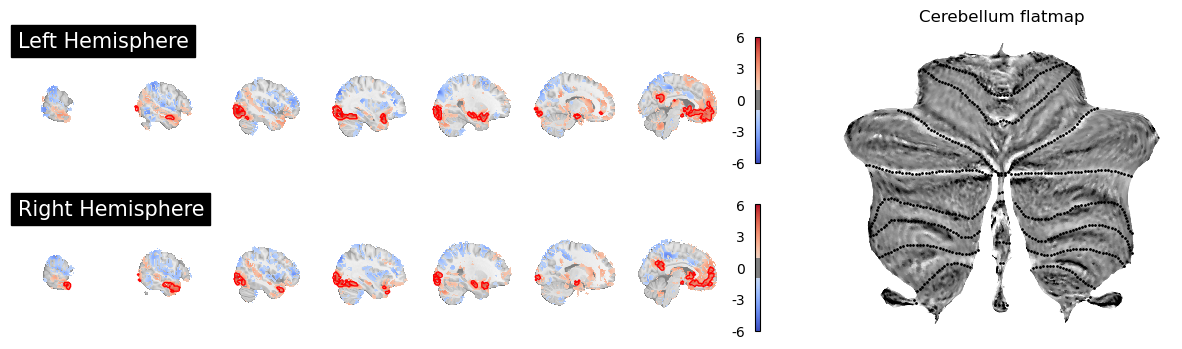

In [9]:
filename = 'zmap_not_asd_SR_HighReward_SimPeer-fb_V_HighReward_Computer-fb'
#threshold = threshold_data[filename+'fpr_'+str(alpha)]
#threshold=1

plot_stat_contours(filename)

### Similar Peer vs Dissimilar Peer

3.2905267314918945


/export/software/neuron/new_conda/envs/py37/lib/python3.7/site-packages/nilearn/plotting/displays/_axes.py:75: UserWarning: No contour levels were found within the data range.
  data_2d.copy(), extent=(xmin, xmax, zmin, zmax), **kwargs


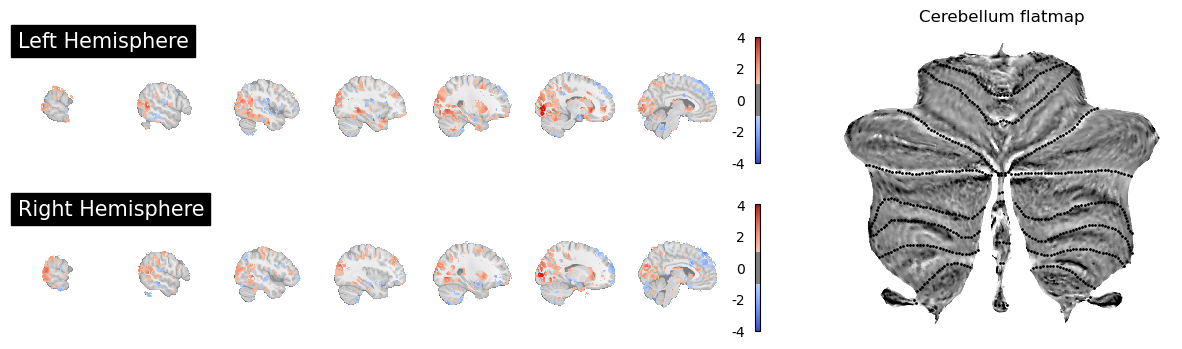

In [10]:
filename = 'zmap_not_asd_SR_HighReward_SimPeer-fb_V_HighReward_DisPeer-fb'

plot_stat_contours(filename)

## Autistic Adolescents

In [11]:
design_matrix = make_second_level_design_matrix(subjs_list_asd)


mni_mask = bids_dir+"/derivatives/fmriprep/sub-SCN101/anat/sub-SCN101_space-MNIPediatricAsym_cohort-5_res-2_label-GM_probseg_bin.nii.gz"

contrasts=['HighReward_SimPeer-fb_V_HighReward_DisPeer-fb', 
           'HighReward_SimPeer-fb_V_HighReward_Computer-fb']
group = 'asd'
tasks = ['SR']
alpha = 0.001
mc = 'fpr'


#threshold_data = {}

for task in tasks:
    for contrast in contrasts:
        
        temp_file_list = []
        for subj in subjs_list_asd:
            temp_file = glob.glob(os.path.join(data_dir,subj,
                                               'zmap_'+task+'_'+contrast+'_run-all.nii.gz'))
            temp_file_list.append(temp_file[0])
        temp_file_list.sort()
        
        print('Calculating '+' group '+contrast+' contrast')
        
        model = SecondLevelModel(mask_img=mni_mask, smoothing_fwhm=8.0)
        model.fit(temp_file_list, design_matrix=design_matrix)
        
        z_map = model.compute_contrast(output_type='z_score')

        z_map.to_filename(os.path.join(data_dir,'group',
                                   'zmap_'+group+'_'+task+'_'+contrast+'_unc.nii.gz'))
            
        # Multiple Comparisons Correction
        z_map_thresh, threshold = threshold_stats_img(z_map, alpha=alpha, height_control=mc)
        z_map_thresh.to_filename(os.path.join(data_dir,'group',
                                   'zmap_'+group+'_'+task+'_'+contrast+'_'+mc+'-'+str(alpha)+'.nii.gz'))
        z_map_thresh_clust = cluster_level_inference(z_map_thresh, alpha=0.05)
        z_map_thresh.to_filename(os.path.join(data_dir,'group',
                                   'zmap_'+group+'_'+task+'_'+contrast+'_'+mc+'-'+str(alpha)+'.nii.gz'))
        z_map_thresh_clust.to_filename(os.path.join(data_dir,'group',
                                   'zmap_'+group+'_'+task+'_'+contrast+'_'+mc+'-'+str(alpha)+'_clust-0.05'+'.nii.gz'))
            
        threshold_data['zmap_'+group+'_'+task+'_'+contrast+'_'+mc+'-'+str(alpha)] = threshold
        

Calculating  group HighReward_SimPeer-fb_V_HighReward_DisPeer-fb contrast
Calculating  group HighReward_SimPeer-fb_V_HighReward_Computer-fb contrast


In [12]:
threshold_data

{'zmap_not_asd_SR_HighReward_SimPeer-fb_V_HighReward_DisPeer-fb_fpr-0.001': 3.2905267314918945,
 'zmap_not_asd_SR_HighReward_SimPeer-fb_V_HighReward_Computer-fb_fpr-0.001': 3.2905267314918945,
 'zmap_asd_SR_HighReward_SimPeer-fb_V_HighReward_DisPeer-fb_fpr-0.001': 3.2905267314918945,
 'zmap_asd_SR_HighReward_SimPeer-fb_V_HighReward_Computer-fb_fpr-0.001': 3.2905267314918945}

### Similar Peer vs Computer Feedback

3.2905267314918945


/export/software/neuron/new_conda/envs/py37/lib/python3.7/site-packages/nilearn/plotting/displays/_axes.py:75: UserWarning: No contour levels were found within the data range.
  data_2d.copy(), extent=(xmin, xmax, zmin, zmax), **kwargs


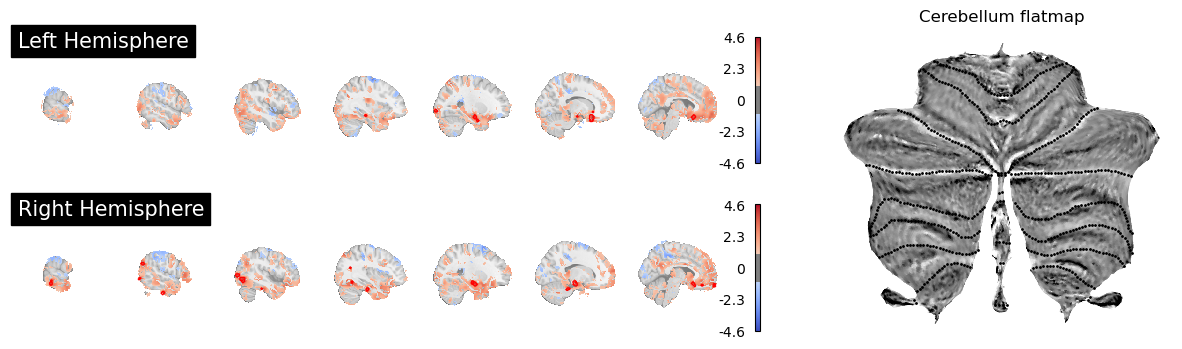

In [13]:
filename = 'zmap_asd_SR_HighReward_SimPeer-fb_V_HighReward_Computer-fb'

plot_stat_contours(filename)

### Similar Peer vs Dissimilar Peer Feedback

3.2905267314918945


/export/software/neuron/new_conda/envs/py37/lib/python3.7/site-packages/nilearn/plotting/displays/_axes.py:75: UserWarning: No contour levels were found within the data range.
  data_2d.copy(), extent=(xmin, xmax, zmin, zmax), **kwargs


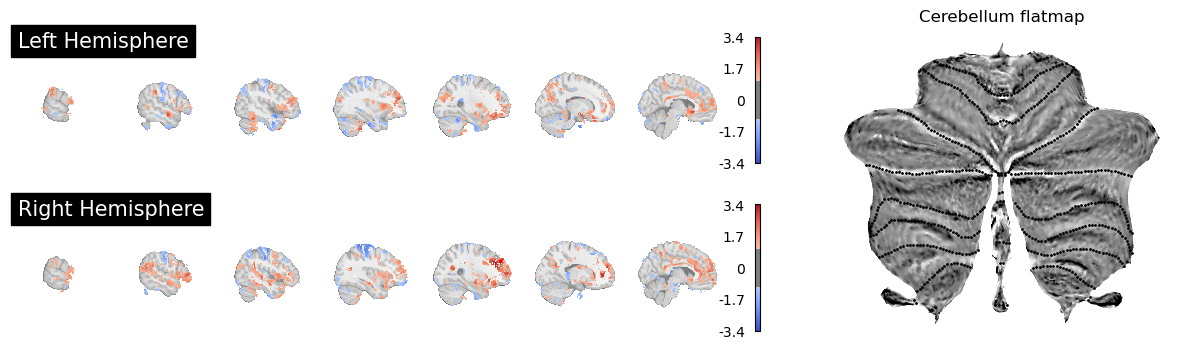

In [14]:
filename = 'zmap_asd_SR_HighReward_SimPeer-fb_V_HighReward_DisPeer-fb'

plot_stat_contours(filename)

# All Subjects

<AxesSubplot:label='conditions', ylabel='scan number'>

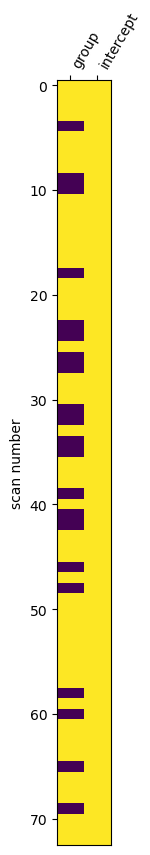

In [15]:
subjs_info_num = subjs_info.copy()
subjs_info_num = subjs_info_num.replace({'group': {'asd': -1, 'not_asd': 1}})
subjs_info_num = subjs_info_num.rename({'participant_id': 'subject_label'}, axis='columns')

design_matrix = make_second_level_design_matrix(subjs_list, subjs_info_num)

plot_design_matrix(design_matrix)

In [16]:
mni_mask = bids_dir+"/derivatives/fmriprep/sub-SCN101/anat/sub-SCN101_space-MNIPediatricAsym_cohort-5_res-2_label-GM_probseg_bin.nii.gz"

contrasts=['HighReward_SimPeer-fb_V_HighReward_DisPeer-fb', 
           'HighReward_SimPeer-fb_V_HighReward_Computer-fb']
contrasts_2nd = ['intercept','group']
tasks = ['SR']
group = 'all'
alpha = 0.001
mc='fpr'
          


#threshold_data = {}

for task in tasks:
    for contrast in contrasts:
        
        temp_file_list = []
        for subj in subjs_list:
            temp_file = glob.glob(os.path.join(data_dir,subj,
                                               'zmap_'+task+'_'+contrast+'_run-all.nii.gz'))
            temp_file_list.append(temp_file[0])
        temp_file_list.sort()
        
        print('Calculating '+' group '+contrast+' contrast')
        
        model = SecondLevelModel(mask_img=mni_mask, smoothing_fwhm=8.0)
        model.fit(temp_file_list, design_matrix=design_matrix)
        
        for contrast_2nd in contrasts_2nd:
            z_map = model.compute_contrast(contrast_2nd, output_type='z_score')

            z_map.to_filename(os.path.join(data_dir,'group',
                                       'zmap_'+group+'_'+task+'_'+contrast+'_'+contrast_2nd+'_unc.nii.gz'))
            
            # Multiple Comparisons Correction
            z_map_thresh, threshold = threshold_stats_img(z_map, alpha=alpha, height_control=mc)
            z_map_thresh.to_filename(os.path.join(data_dir,'group',
                                       'zmap_'+group+'_'+task+'_'+contrast+'_'+contrast_2nd+'_'+mc+'-'+str(alpha)+'.nii.gz'))
            z_map_thresh_clust = cluster_level_inference(z_map_thresh, alpha=0.05)
            z_map_thresh.to_filename(os.path.join(data_dir,'group',
                                       'zmap_'+group+'_'+task+'_'+contrast+'_'+contrast_2nd+'_'+mc+'-'+str(alpha)+'.nii.gz'))
            z_map_thresh_clust.to_filename(os.path.join(data_dir,'group',
                                       'zmap_'+group+'_'+task+'_'+contrast+'_'+contrast_2nd+'_'+mc+'-'+str(alpha)+'_clust-0.05'+'.nii.gz'))
            
            threshold_data['zmap_'+group+'_'+task+'_'+contrast+'_'+contrast_2nd+'_'+mc+'-'+str(alpha)] = threshold

Calculating  group HighReward_SimPeer-fb_V_HighReward_DisPeer-fb contrast
Calculating  group HighReward_SimPeer-fb_V_HighReward_Computer-fb contrast


3.2905267314918945


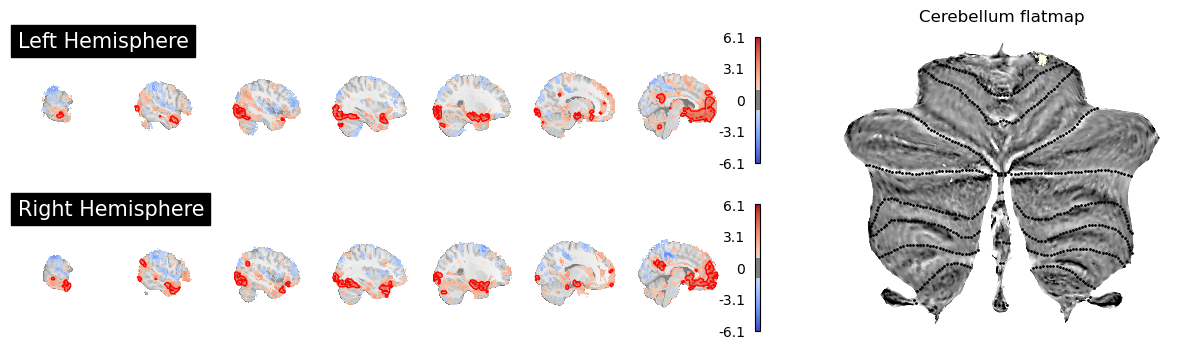

In [17]:
filename = 'zmap_all_SR_HighReward_SimPeer-fb_V_HighReward_Computer-fb_intercept'

plot_stat_contours(filename)

3.2905267314918945


/export/software/neuron/new_conda/envs/py37/lib/python3.7/site-packages/nilearn/plotting/displays/_axes.py:75: UserWarning: No contour levels were found within the data range.
  data_2d.copy(), extent=(xmin, xmax, zmin, zmax), **kwargs


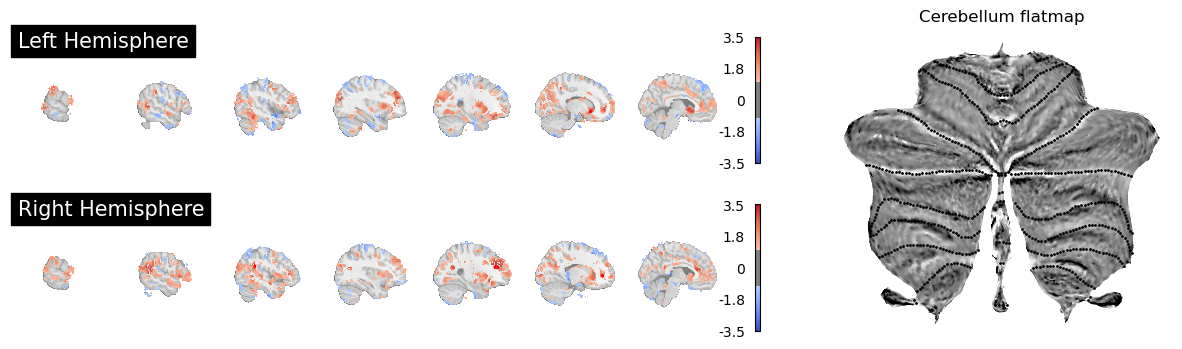

In [18]:
filename = 'zmap_all_SR_HighReward_SimPeer-fb_V_HighReward_DisPeer-fb_intercept'

plot_stat_contours(filename)

## Group differences 
Where non-autistic > autistic

### Similar Peer vs Computer

3.2905267314918945


/export/software/neuron/new_conda/envs/py37/lib/python3.7/site-packages/nilearn/plotting/displays/_axes.py:75: UserWarning: No contour levels were found within the data range.
  data_2d.copy(), extent=(xmin, xmax, zmin, zmax), **kwargs


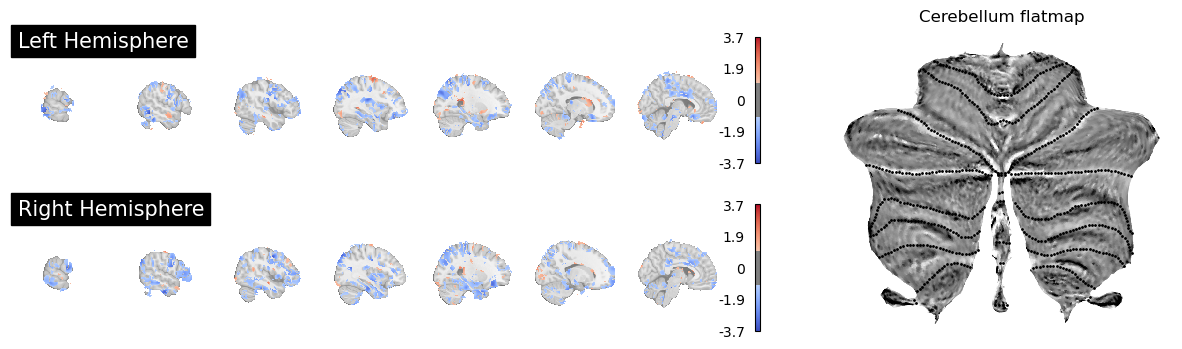

In [19]:
filename = 'zmap_all_SR_HighReward_SimPeer-fb_V_HighReward_Computer-fb_group'

plot_stat_contours(filename)

### Similar Peer vs Dissimilar Peer

3.2905267314918945


/export/software/neuron/new_conda/envs/py37/lib/python3.7/site-packages/nilearn/plotting/displays/_axes.py:75: UserWarning: No contour levels were found within the data range.
  data_2d.copy(), extent=(xmin, xmax, zmin, zmax), **kwargs


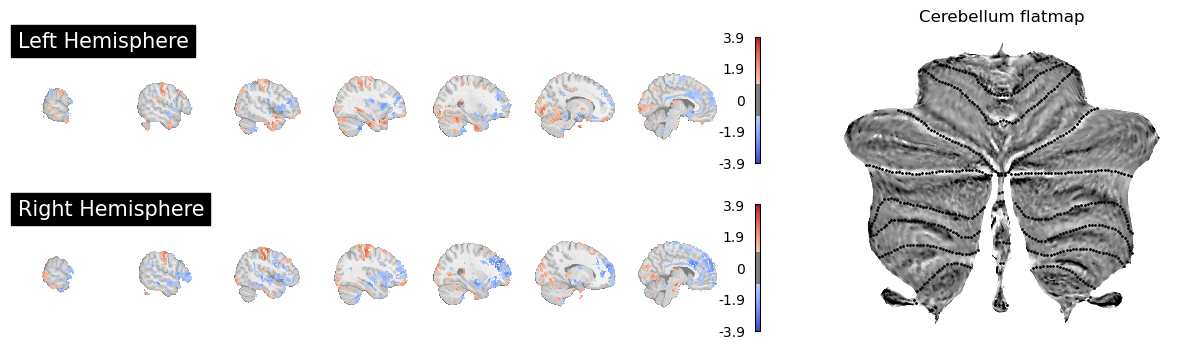

In [20]:
filename = 'zmap_all_SR_HighReward_SimPeer-fb_V_HighReward_DisPeer-fb_group'

plot_stat_contours(filename)

#### All wins > All losses

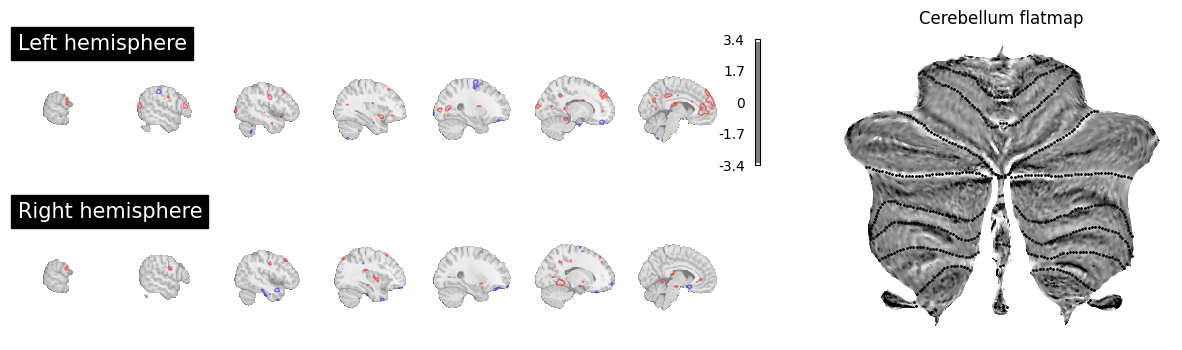

In [54]:
filename = 'zmap_all_mdoors_all_winVlos_group_'
threshold = threshold_data[filename+'fpr_'+str(alpha)]

plot_stat_map_cb(filename+'unc', threshold)

### Social Task

#### Positive win > Positive loss

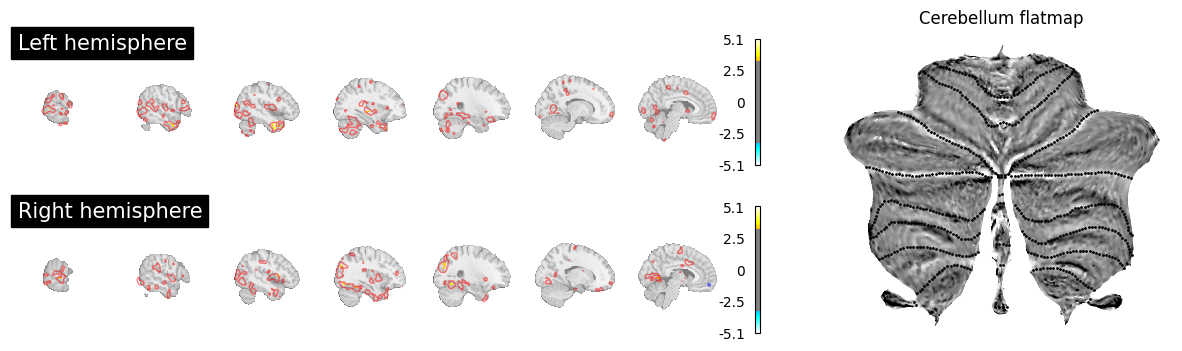

In [49]:
filename = 'zmap_all_social_positive_winVlos_group_'
threshold = threshold_data[filename+'fpr_'+str(alpha)]

plot_stat_map_cb(filename+'unc', threshold)

#### All wins > All losses

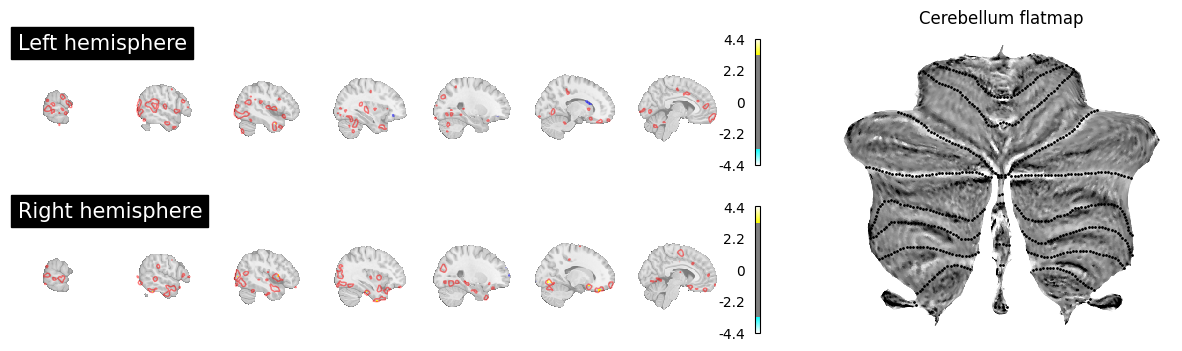

In [52]:
filename = 'zmap_all_social_all_winVlos_group_'
threshold = threshold_data[filename+'fpr_'+str(alpha)]

plot_stat_map_cb(filename+'unc', threshold)

## Accounting for Age

### Monetary Task

#### Positive win > Positive loss

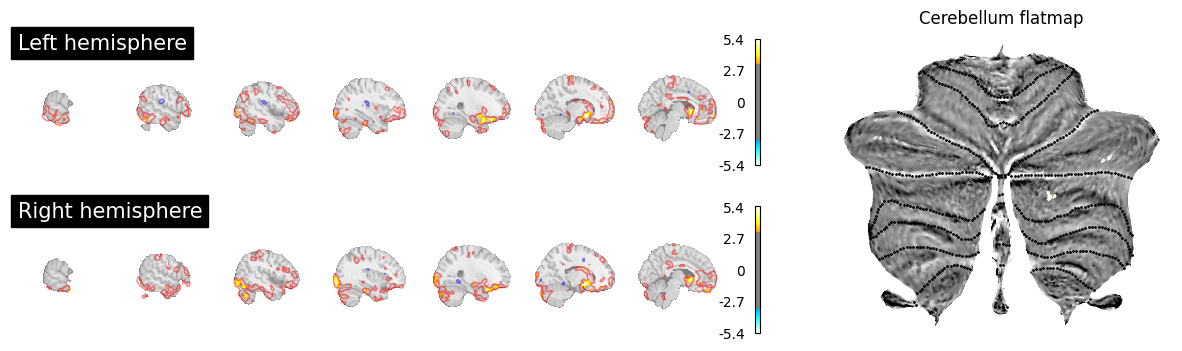

In [55]:
filename = 'zmap_all_mdoors_positive_winVlos_intercept_'
threshold = threshold_data[filename+'fpr_'+str(alpha)]

plot_stat_map_cb(filename+'unc', threshold)

#### All wins > All losses

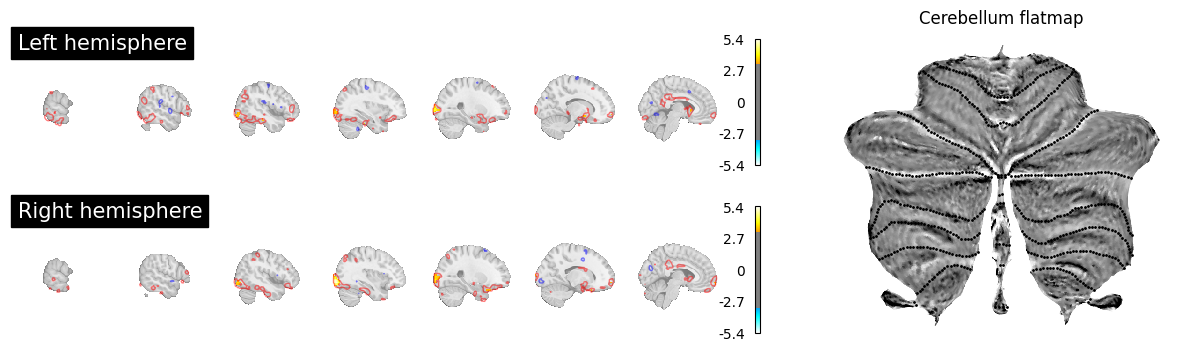

In [56]:
filename = 'zmap_all_mdoors_all_winVlos_intercept_'
threshold = threshold_data[filename+'fpr_'+str(alpha)]

plot_stat_map_cb(filename+'unc', threshold)

### Social Task

#### Positive wins > Positive losses

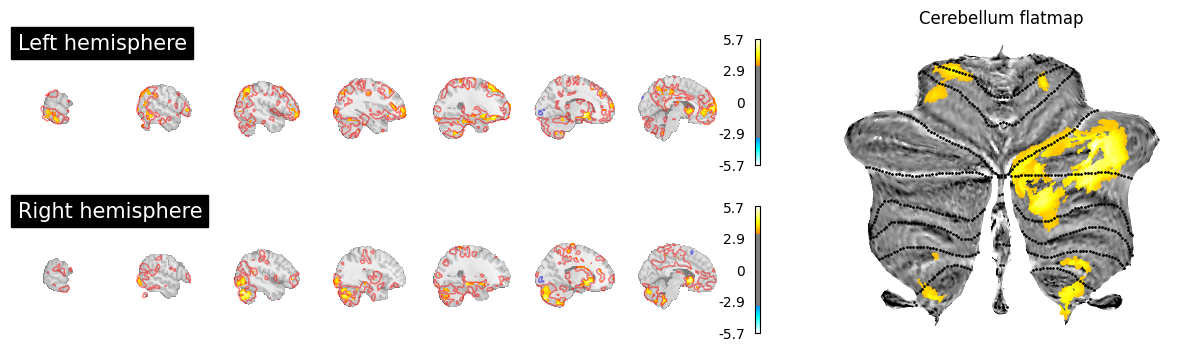

In [57]:
filename = 'zmap_all_social_positive_winVlos_intercept_'
threshold = threshold_data[filename+'fpr_'+str(alpha)]

plot_stat_map_cb(filename+'unc', threshold)

#### All wins > All losses

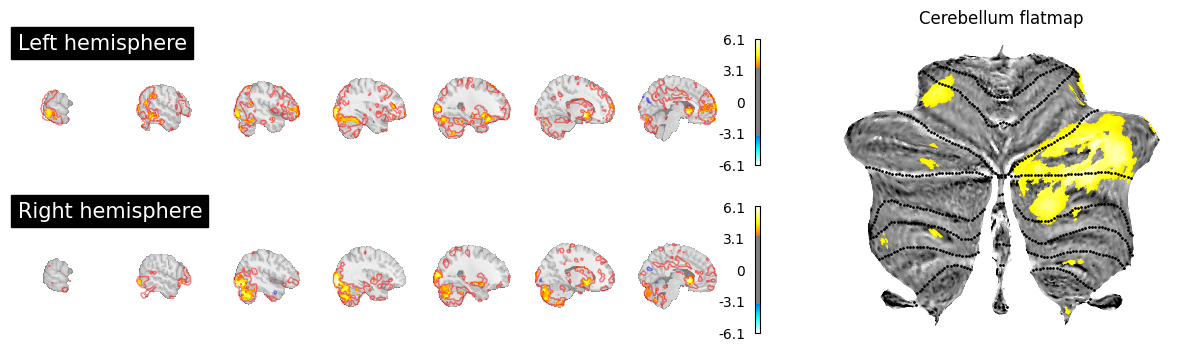

In [58]:
filename = 'zmap_all_social_all_winVlos_intercept_'
threshold = threshold_data[filename+'fpr_'+str(alpha)]

plot_stat_map_cb(filename+'unc', threshold)

# Behavioral Analysis

In [62]:
behav_data = pd.read_excel(bids_dir+'/derivatives/behavioral/aggregate_full_data_SPSS_020419.xlsx',
                          sheet_name='Sheet1')

behav_data.head()

Order Subject  ch_totanx  ch_socialanx  p_totanx  p_socialanx  bfne  \
0      1    s010         51            14         7            1    33   
1      1    s011         12             3         4            1    31   
2      1    s013          8             4         1            1    13   
3      1    s015         18             5         1            0    21   
4      2    s024         21            10         0            0    28   

   ch_cdi_total  ch_cdi_interpersonal  ch_cdi_anhedonia  ...  \
0          11.0                   0.0               5.0  ...   
1           8.0                   0.0               3.0  ...   
2           5.0                   0.0               2.0  ...   
3           NaN                   NaN               NaN  ...   
4           1.0                   0.0               0.0  ...   

   FB_VS_6mm_R_Like_Lose_NZMean_1  FB_VS_6mm_R_Like_Lose_NZCount_1  \
0                        0.029036                            123.0   
1                             NaN                              NaN   
2                       -0.308424                            123.0   
3                       -0.798996                            123.0   
4                             NaN                              NaN   

   FB_VS_6mm_R_Like_Lose_NZMin_1  FB_VS_6mm_R_Like_Lose_NZMax_1  \
0                      -0.296210                       0.647286   
1                            NaN                            NaN   
2                      -0.554069                       0.030482   
3                      -1.841710                      -0.031699   
4                            NaN                            NaN   

  FB_VS_6mm_R_Like_Win_Mean_1  FB_VS_6mm_R_Like_Win_NZMean_1  \
0                    0.256033                       0.256033   
1                         NaN                            NaN   
2                    0.093248                       0.093248   
3                    0.004660                       0.004660   
4                         NaN                            NaN   

   FB_VS_6mm_R_Like_Win_NZCount_1  FB_VS_6mm_R_Like_Win_NZMin_1  \
0                           123.0                     -0.022722   
1                             NaN                           NaN   
2                           123.0                     -0.183241   
3                           123.0                     -1.020790   
4                             NaN                           NaN   

   FB_VS_6mm_R_Like_Win_NZMax_1  FB_VS6mm_L_Correct_DislikeVsLike  
0                      0.752379                         -0.127002  
1                           NaN                               NaN  
2                      1.003483                         -0.167305  
3                      0.809193                          0.485397  
4                           NaN                               NaN  

[5 rows x 1551 columns]

In [63]:
behav_data_fltr = behav_data[['Subject','ch_totanx', 'ch_cdi_total']]

behav_data_fltr['Subject'] = behav_data_fltr['Subject'].str.replace('s','sub-')

behav_data_fltr = behav_data_fltr.rename(columns={'Subject':'subject_label'})

behav_data_fltr.head()

/Users/haroonpopal/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


subject_label  ch_totanx  ch_cdi_total
0       sub-010         51          11.0
1       sub-011         12           8.0
2       sub-013          8           5.0
3       sub-015         18           NaN
4       sub-024         21           1.0

/Users/haroonpopal/anaconda3/envs/py37/lib/python3.7/site-packages/nilearn/glm/first_level/design_matrix.py:475: UserWarning: Attention: Design matrix is singular. Aberrant estimates are expected.
  warn('Attention: Design matrix is singular. Aberrant estimates '


<AxesSubplot:label='conditions', ylabel='scan number'>

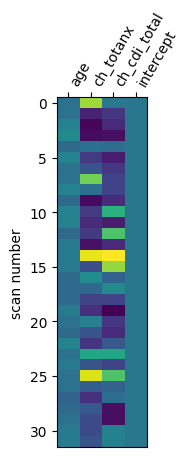

In [64]:
# Add behavioral data to design matrix

subjs_info_kids_behav = subjs_info_kids_fltr.merge(behav_data_fltr, on='subject_label')


design_matrix = make_second_level_design_matrix(subjs_list_kids, subjs_info_kids_behav)

plot_design_matrix(design_matrix)

In [65]:
#design_matrix = make_second_level_design_matrix(subjs_list_kids, subjs_info_kids_fltr)
mni_mask = bids_dir+"/derivatives/fmriprep/sub-010/anat/sub-010_space-MNI152NLin2009cAsym_label-GM_probseg_bin.nii.gz"

#contrasts = ['valence_x_outcome',
#             'positive','positive_win','positive_loss',
#             'negative','negative_win','negative_loss']
contrasts=['all_winVlos', 'positive_winVlos']
contrasts_2nd = ['ch_totanx','ch_cdi_total']
tasks = ['mdoors','social']
group = 'kids'
alpha = 0.001


threshold_data = {}

for task in tasks:
    for contrast in contrasts:
        
        temp_file_list = []
        for subj in subjs_list_kids:
            temp_file = glob.glob(os.path.join(data_dir,subj,'zmap_'+task+'_'+contrast+'.nii'))
            temp_file_list.append(temp_file[0])
        temp_file_list.sort()
        
        print('Calculating '+task+' group '+contrast+' contrast')
        
        model = SecondLevelModel(mask_img=mni_mask, smoothing_fwhm=8.0)
        model.fit(temp_file_list, design_matrix=design_matrix)
        
        for contrast_2nd in contrasts_2nd:
            z_map = model.compute_contrast(contrast_2nd, output_type='z_score')

            z_map.to_filename(os.path.join(data_dir,'group',
                                       'zmap_'+group+'_'+task+'_'+contrast+'_'+contrast_2nd+'_unc.nii.gz'))
            
            # Multiple Comparisons Correction
            z_map_thresh, threshold = threshold_stats_img(z_map, alpha=alpha, height_control='fpr')
            z_map_thresh.to_filename(os.path.join(data_dir,'group',
                                       'zmap_'+group+'_'+task+'_'+contrast+'_'+contrast_2nd+'_fpr.nii.gz'))
            
            threshold_data['zmap_'+group+'_'+task+'_'+contrast+'_'+contrast_2nd+'_fpr_'+str(alpha)] = threshold

Calculating mdoors group all_winVlos contrast
Calculating mdoors group positive_winVlos contrast
Calculating social group all_winVlos contrast
Calculating social group positive_winVlos contrast


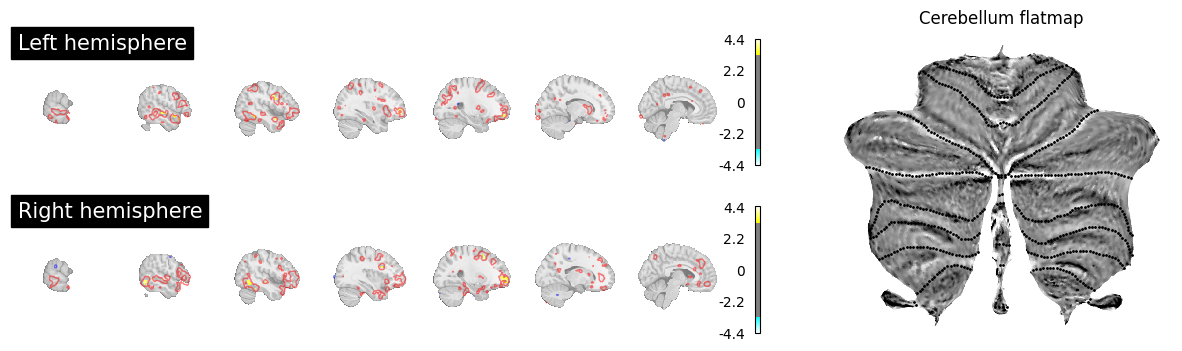

In [70]:
filename = 'zmap_kids_social_positive_winVlos_ch_cdi_total_'
threshold = threshold_data[filename+'fpr_'+str(alpha)]
#threshold=1

plot_stat_map_cb(filename+'unc', threshold)

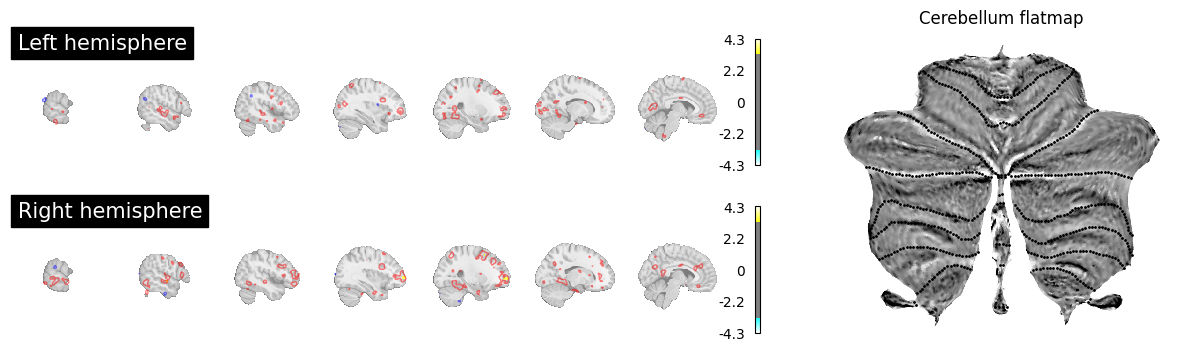

In [69]:
filename = 'zmap_kids_social_all_winVlos_ch_cdi_total_'
threshold = threshold_data[filename+'fpr_'+str(alpha)]
#threshold=1

plot_stat_map_cb(filename+'unc', threshold)